## Introduction
In the realm of modern medicine, the fusion of technology and healthcare has opened new frontiers for diagnosis and treatment, particularly in the critical care of neurological conditions. The Sunstella Foundation, in collaboration with Persyst, Jazz Pharmaceuticals, and the Clinical Data Animation Center (CDAC), has launched a pioneering Kaggle competition with the aim to revolutionize the field of neurocritical care through technological innovation. This competition challenges participants to develop advanced machine learning models capable of detecting and classifying various patterns of brain activity, including seizures, from electroencephalography (EEG) signals.

Electroencephalography, a crucial tool in monitoring critically ill patients, captures the electrical activity of the brain and provides invaluable insights into neurological conditions. However, the traditional reliance on manual analysis of EEG recordings by specialized neurologists presents several challenges, including time consumption, high costs, susceptibility to errors, and variability in interpretation. By automating the analysis of EEG data, the competition aims to enhance the accuracy and efficiency of neurocritical care, thereby accelerating the detection and treatment of seizures and other harmful brain activities. This endeavor not only promises significant improvements in patient care but also supports the advancement of epilepsy research and drug development.

As we stand on the brink of this transformative leap in neurocritical care, the competition invites bright minds to contribute to a future where rapid and accurate EEG analysis can save lives and improve the quality of care for patients across the globe. With just two months to make your mark, the challenge is set to foster innovation, collaboration, and technological breakthroughs in the pursuit of excellence in healthcare.

In [5]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf
import os

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

2024-03-04 16:34:59.565978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 16:34:59.566084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 16:34:59.697639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.5
KerasCV: 0.8.2


In [7]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

## Setting Up the Environment
Before we begin loading the data, it's essential to ensure a consistent environment for reproducibility and accuracy. This line of code sets a random seed using Keras, a deep learning API written in Python, running on top of the machine learning platform TensorFlow. This random seed helps in maintaining the reproducibility of results.

In [8]:
keras.utils.set_random_seed(CFG.seed)

## Preparing the File Paths
The competition data is stored in a specific directory structure on Kaggle. The BASE_PATH variable holds the path to the main directory where the training and test data are located. To facilitate the handling of spectrograms, a temporary directory (SPEC_DIR) is created for both training and test spectrograms. This organizational step ensures that the data is easily accessible and manageable for processing.

In [9]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

## Loading the Data
The training and testing data are loaded from their respective CSV files into Pandas DataFrames. These DataFrames are crucial for data manipulation and analysis in Python. For each record, the paths to the EEG data and spectrogram data (both original and newly generated) are constructed. Additionally, the 'class_name' and 'class_label' columns are created based on the 'expert_consensus' column, facilitating easier access and manipulation of the target variables.

In [10]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


## Data Processing: Transforming Spectrograms for Machine Learning
After successfully loading the EEG data and spectrogram paths, the next essential step in preparing for machine learning modeling is data processing. This section focuses on transforming the EEG spectrogram data from its original format into a more analysis-friendly structure. We define a specific function to process the spectrogram data associated with each EEG recording, ensuring the data is in the optimal format for our machine learning models.

### Defining the Processing Function
The function process_spec is designed to process a single spectrogram identified by spec_id. This function reads the spectrogram data from its .parquet file, fills any missing values with zeros, and transposes the matrix to match the expected input shape for most deep learning frameworks, where the frequency dimension precedes the time dimension. Finally, the processed spectrogram is saved in a .npy file for efficient access during model training and evaluation. This step is crucial for maintaining data integrity and ensuring consistent input to the models.

In [11]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Data Processing: Transforming Spectrograms for Machine Learning
After successfully loading the EEG data and spectrogram paths, the next essential step in preparing for machine learning modeling is data processing. This section focuses on transforming the EEG spectrogram data from its original format into a more analysis-friendly structure. We define a specific function to process the spectrogram data associated with each EEG recording, ensuring the data is in the optimal format for our machine learning models.

### Defining the Processing Function
The function process_spec is designed to process a single spectrogram identified by spec_id. This function reads the spectrogram data from its .parquet file, fills any missing values with zeros, and transposes the matrix to match the expected input shape for most deep learning frameworks, where the frequency dimension precedes the time dimension. Finally, the processed spectrogram is saved in a .npy file for efficient access during model training and evaluation. This step is crucial for maintaining data integrity and ensuring consistent input to the models.

### Processing the Data in Parallel
Given the potentially large volume of spectrogram data, processing each file sequentially could be time-consuming. To expedite this process, we employ parallel processing using the joblib library, which allows us to process multiple spectrograms simultaneously, significantly reducing the overall processing time.

For both training/validation and testing datasets, we first identify the unique spectrogram_ids. Then, we use joblib's Parallel function to apply the process_spec function to each spectrogram ID in parallel. This parallelization approach is applied separately to the training/validation and testing sets to ensure all spectrograms are processed efficiently.

In [12]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

### Split Strategy: Stratified Group K-Fold Cross-Validation
To train and validate our machine learning models effectively, it's crucial to split the dataset into training and validation sets in a way that ensures both representativity and fairness. Given the nature of the EEG data, where multiple records may belong to the same patient, a sophisticated split strategy is necessary to avoid data leakage and ensure the model's generalizability. This section describes the implementation of a Stratified Group K-Fold Cross-Validation approach, which addresses these concerns.

### Understanding Stratified Group K-Fold Cross-Validation
Stratified Group K-Fold Cross-Validation is a hybrid method combining the principles of stratification and group-based splitting. Stratification ensures that each fold is a good representative of the whole by maintaining the same distribution of classes in each fold as in the full dataset. Grouping ensures that all records belonging to the same group (in this case, the same patient) are treated as a single unit, either entirely in the training set or entirely in the validation set. This approach is particularly useful in medical datasets where multiple samples come from the same patient, as it prevents the same patient's data from appearing in both the training and validation sets, thus avoiding data leakage.

In [13]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Dataset Sampling and Preparation for Training and Validation
Following the stratified group k-fold split strategy, the next step in preparing our dataset for machine learning involves sampling from the full dataset and organizing the data into training and validation sets. This process is critical for training robust models and evaluating their performance accurately. The code snippets provided outline how to sample the data, and prepare it for training and validation phases.

### Sampling the Data
To ensure diversity and manageability, we sample the dataset by selecting one record per spectrogram_id. This approach reduces redundancy and focuses on a varied subset of the data, enhancing the model's ability to generalize across different EEG patterns.

### Preparing the Datasets
For both training and validation sets, we extract the paths to the pre-processed spectrogram .npy files (spec2_path), the offsets (spectrogram_label_offset_seconds), and the class labels (class_label). These elements are crucial for constructing the datasets in a way that models can effectively learn from them.

In [14]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


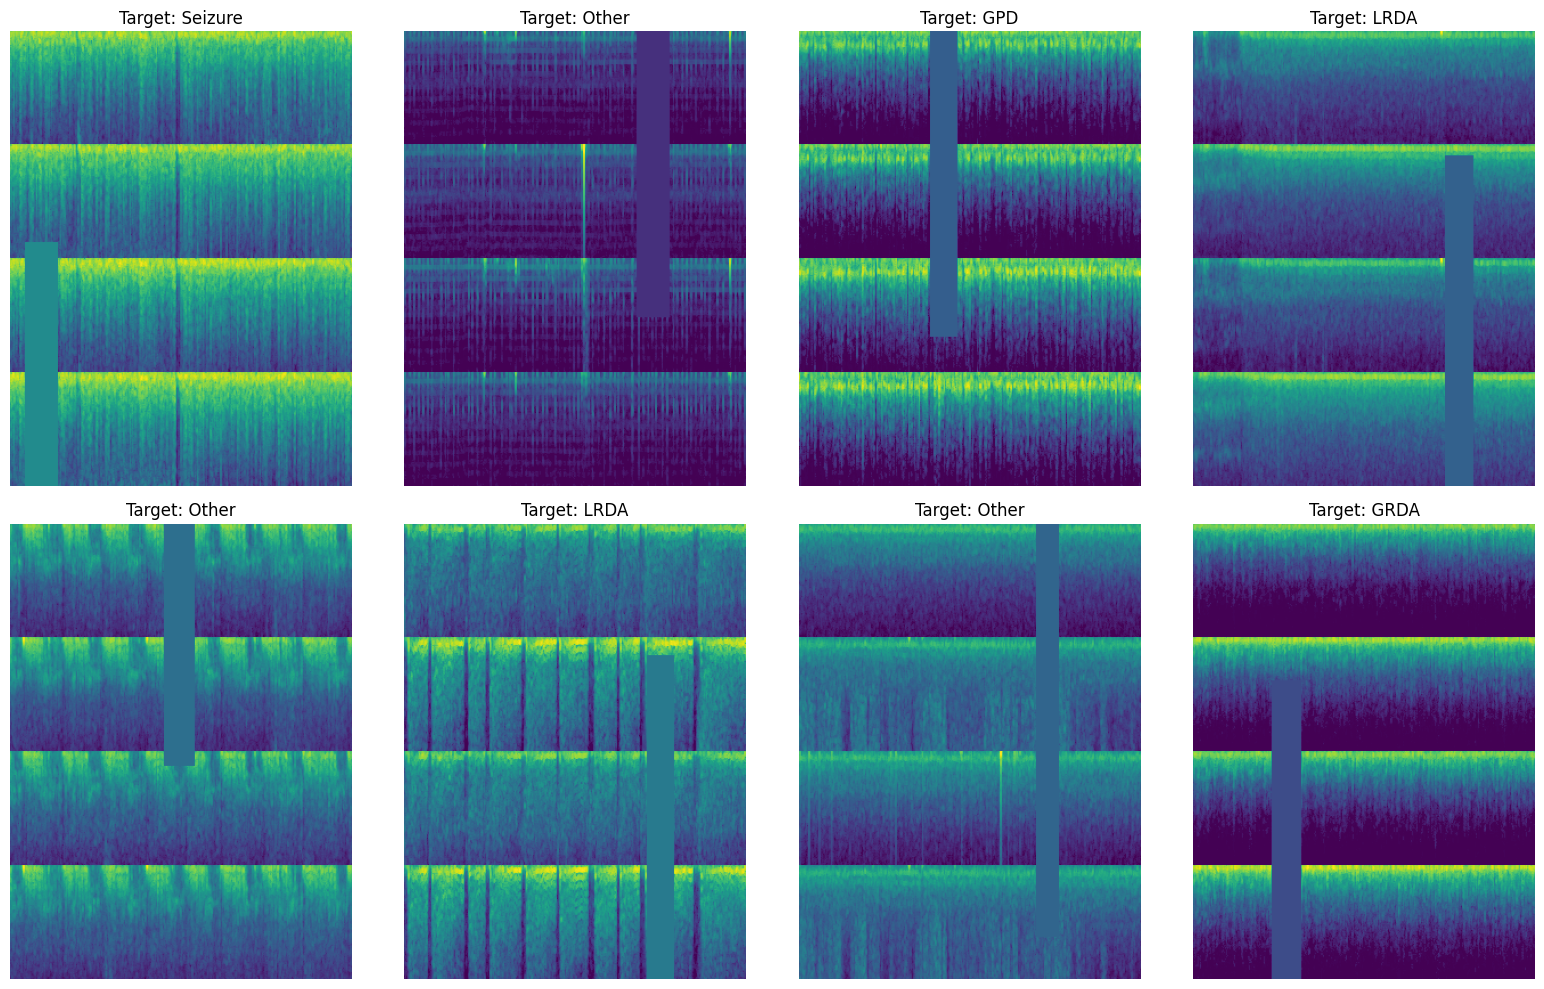

In [24]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### Overview of Kullback-Leibler Divergence
The Kullback-Leibler Divergence, or KL Divergence, is a measure from information theory that quantifies how one probability distribution diverges from a second, expected probability distribution. In machine learning, it's often used as a loss function when the goal involves matching a predicted probability distribution to a target distribution. The KL Divergence is particularly useful in scenarios where understanding the relative entropy between distributions is crucial, such as in probabilistic model predictions.

### Application in EEG Signal Classification
For this competition, where the task is to predict a probability distribution across several classes (seizure types and brain activity patterns), KL Divergence serves as an effective loss function. It penalizes predictions that diverge significantly from the true distribution of classes, thus encouraging the model to produce probabilities that closely match the observed distribution in the training data.

In [15]:
LOSS = keras.losses.KLDivergence()

## Model
The EEG signal classifier leverages the power of a pre-trained EfficientNetV2 architecture, adapted for the specific task of classifying EEG signals into distinct categories of brain activity. By selecting an efficient architecture and optimizing it with a carefully chosen loss function and optimizer, the model is well-positioned to learn from the complex patterns present in EEG data. This approach encapsulates the potential of deep learning in transforming neurocritical care, offering a path towards rapid, accurate classification of EEG signals for improved patient outcomes.

In [16]:
# Build Classifier
model = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes
)

# Compile the model  
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [17]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

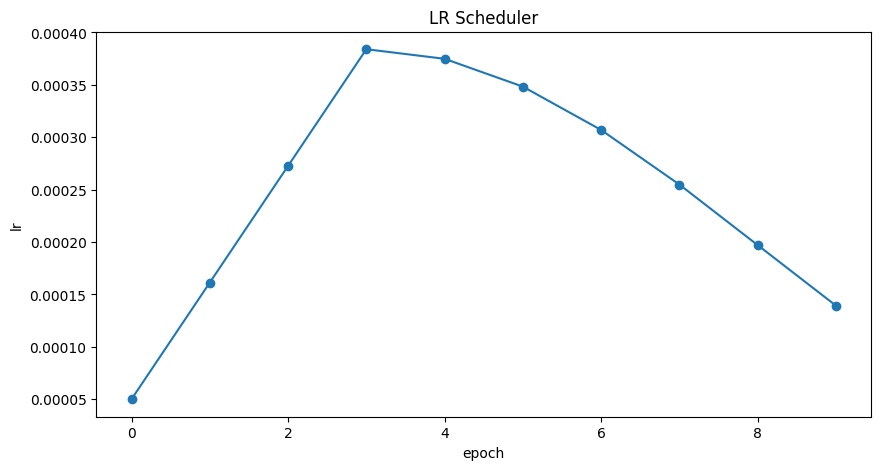

In [18]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

In [19]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [20]:
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 152s 626ms/step - loss: 1.4350 - val_loss: 1.3592 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 493ms/step - loss: 1.1383 - val_loss: 1.0786 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - loss: 0.9920 - val_loss: 1.0134 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 498ms/step - loss: 0.8781 - val_loss: 0.9197 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 492ms/step - loss: 0.8311 - val_loss: 0.8708 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - loss: 0.7771 - val_loss: 0.8772 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 493ms/step - loss: 0.7277 - val_loss: 0.8595 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 495ms/step - loss: 0.6973 - val_loss: 0.8593 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 493ms/step - loss: 

In [21]:
model.load_weights("best_model.keras")

In [22]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

In [23]:
preds = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [25]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.007542,0.038812,0.000347,0.90707,0.003742,0.042487


## Conclusion
The use of a pre-trained EfficientNetV2B2 model as the backbone of our classifier, optimized with Kullback-Leibler Divergence as the loss function, represents the cutting edge of machine learning applications in healthcare. This competition, beyond its immediate challenge, shows the significant potential of AI and machine learning in advancing medical diagnostics and treatment strategies. By automating the analysis of EEG signals, we move closer to a future where rapid and accurate detection of seizures and other harmful brain activity can significantly impact outcomes for patients in critical care.

As participants in this competition, the opportunity to contribute to such a transformative advancement in healthcare is not only a technical challenge but a noble cause. The efforts and innovations that emerge from this challenge are poised to enhance the capabilities of neurocritical care, epilepsy treatment, and drug development, marking a significant step forward in the intersection of technology and medicine.